## Libraries

In [47]:
## Importing/Formatting Data
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

## Natural Language Processing
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk
import spacy

# You might need to download the NLTK resources the first time you run the script
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

## Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

## Evaluation & Visualizing Results
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In [48]:
def import_bulk_transcript_data(symbols,start_year,api_key):

  SYMBOLS = []
  DATE = []
  TRANSCRIPT = []

  for i in tqdm(range(len(symbols))):
    s = symbols[i]
    for y in range(start_year,2022,1):
      for q in range(1,5):
        try:
          url = f'https://financialmodelingprep.com/api/v3/earning_call_transcript/{s}?year={y}&quarter={q}&apikey={api_key}'
          data = requests.get(url).json()
          transcript = data[0]['content']
          date = data[0]['date']
          SYMBOLS.append(s)
          DATE.append(date)
          TRANSCRIPT.append(transcript)
        except:
          pass

  transcript_df = pd.DataFrame({
      "Symbol":SYMBOLS,
      "Date":DATE,
      "Transcript":TRANSCRIPT
  })

  transcript_df['Date'] = pd.to_datetime(transcript_df['Date'])
  transcript_df['Date'] = transcript_df['Date'].dt.strftime('%Y-%m-%d')
  transcript_df['Date'] = pd.to_datetime(transcript_df['Date'])

  return transcript_df

In [49]:
def import_bulk_price_data(api_key,symbols):

  dfs = []

  for i in tqdm(range(len(symbols))):
    s = symbols[i]
    prices = requests.get(f'https://financialmodelingprep.com/api/v3/historical-chart/1day/{s}?from="2023-01-01"&to="2024-01-01"&apikey={api_key}').json()
    price_df = pd.json_normalize(prices).sort_values(by='date').reset_index(drop=True)
    price_df['date'] = pd.to_datetime(price_df['date'])
    price_df['date'].dt.strftime('%Y-%m-%d')
    price_df['monthly_return'] = price_df['close'].pct_change(periods=20).shift(-20)
    price_df['symbol'] = s
    dfs.append(price_df)
    combined_df = pd.concat(dfs, ignore_index=True)
  return combined_df

## Get Data

In [50]:
api_key = "your_api_key_here"
stocks = ["TSLA","AMD","AAPL","AMZN","F","NVDA","BAC","INTC","T","PFE","GOOGL","UBER",
          "MSFT","VZ","GOOG","VALE","XOM","META","CMCSA","CSCO","PCG","PBR","C","GM","WFC"]

#### Transcript

#### Price Data

In [51]:
price_data = import_bulk_price_data(api_key=api_key,symbols=stocks)

100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


#### Transcript Data

In [52]:
transcript_data = import_bulk_transcript_data(symbols = stocks,start_year = 2015,api_key=api_key)

100%|██████████| 25/25 [00:43<00:00,  1.76s/it]


#### Format Date and Inner Join

In [53]:
merged_df = pd.merge(transcript_data, price_data, left_on=['Symbol', 'Date'], right_on=['symbol', 'date'], how='inner')
merged_df = merged_df[['Date', 'Symbol', 'Transcript', 'monthly_return']]
merged_df.head()

,Date,Symbol,Transcript,monthly_return
0,2015-05-05,TSLA,"Executives: Aaron Chew - Vice President, Inves...",0.068899
1,2015-07-30,TSLA,Executives: Aaron N. Chew - Vice President-Inv...,-0.089376
2,2015-10-30,TSLA,"Executives: Aaron Chew - Vice President, Inves...",0.112319
3,2016-02-10,TSLA,Executives: Aaron Chew - VP of Investor Relati...,0.427975
4,2016-05-05,TSLA,"Executives: Jeff Evanson - Investor Relations,...",0.035461


## Modeling

#### Preprocess

In [54]:
# Function to remove stop words, perform lemmatization
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Tokenization
    tokens = nltk.word_tokenize(text.lower())

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# Apply the preprocessing functions to the 'Transcript' column
merged_df['Cleaned_Transcript'] = merged_df['Transcript'].apply(preprocess_text)

# Define features and target variable
X = merged_df[['Cleaned_Transcript']]
y = merged_df['monthly_return']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Modeling Pipeline

In [55]:
# Create a pipeline with TfidfVectorizer and XGBRegressor
preprocessor = ColumnTransformer(
    transformers=[
        ('cleaned_transcript', TfidfVectorizer(ngram_range=(1, 3)), 'Cleaned_Transcript')
    ]
)

model = make_pipeline(preprocessor, XGBRegressor(objective='reg:squarederror'))

#### Fitting the Model & Evaluation

In [56]:
# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Absolute Percentage Error: {mape}')
print(f'Variance Explained: {r_squared}')

Mean Absolute Percentage Error: 2.614450463541667
Variance Explained: -0.1986754813124758


/tmp/ipykernel_20918/246702923.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = y_test, y = y_pred, palette='viridis',alpha=0.7, s=100)


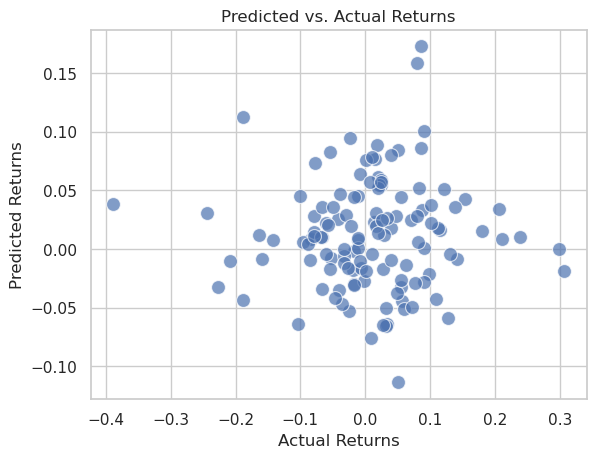

In [57]:
sns.set(style='whitegrid')

# Create a scatter plot
sns.scatterplot(x = y_test, y = y_pred, palette='viridis',alpha=0.7, s=100)

# Add labels and title
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Predicted vs. Actual Returns')

# Display the plot
plt.show()

----

In [41]:
pred = list(y_pred > 0)

In [42]:
test = list(y_test.values > 0)

In [43]:
len(y_pred)

121

In [44]:
len(test)

121

In [45]:
df = pd.DataFrame({
    "pred":pred,
    "test":test
})

In [60]:
df['column3'] = df['pred'] == df['test']

In [63]:
df.column3.sum() / len(df)

0.5454545454545454